In [1]:
##BUILD AND SAVE DATASET##
img_folder = 'images'
from tflearn.data_utils import build_hdf5_image_dataset
import os

#Deletes hidden .DS_Store file from sub
try:
    for sub in os.listdir(img_folder):
        if not sub  == '.DS_Store':
            os.remove('{}/{}/.DS_Store'.format(img_folder,sub))
except:
    pass

build_hdf5_image_dataset(img_folder, 
                         image_shape=(128, 128), #resizes
                         mode='folder', 
                         output_path='dataset.h5', #saves data to a file
                         categorical_labels=True, 
                         grayscale=False,
                         normalize=True)

##Only need run the above once##

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


[1,0] == CALZONE
[0,1] == PIZZA
Eg: [Calzone-ness, Pizza-ness]

In [2]:
##LOAD IMAGES##
import h5py
import numpy as np
from tflearn.data_utils import shuffle
h5f = h5py.File('dataset.h5', 'r')
data = h5f['X']
labels = h5f['Y']
data, labels = shuffle(data,labels) #shuffles the data and labels in parallel

In [3]:
##CONSTRUCTING THE NETWORK##

from tflearn.layers.core import input_data, fully_connected, dropout
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression

net = input_data(shape=(None,128,128,3))
net = conv_2d(net, 32, 3, activation='relu',regularizer='L2')
net = max_pool_2d(net, 2)

net = conv_2d(net, 64, 3, activation='relu',regularizer='L2')
net = max_pool_2d(net, 2)

net = conv_2d(net, 128, 3, activation='relu',regularizer='L2')
net = max_pool_2d(net, 2)

net = conv_2d(net, 256, 3, activation='relu',regularizer='L2')
net = max_pool_2d(net, 2)

net = conv_2d(net, 512, 3, activation='relu',regularizer='L2')
net = max_pool_2d(net, 2)

net = conv_2d(net, 256, 3, activation='relu',regularizer='L2')
net = max_pool_2d(net, 2)


net = fully_connected(net, 1024, activation='relu')
net = dropout(net, 0.9)

net = fully_connected(net, 2, activation='softmax')

net = regression(net, optimizer='adam', learning_rate=1e-3,
                     loss='categorical_crossentropy')

In [4]:
##SETUP THE TRAINING##

from tflearn.models import dnn
model = dnn.DNN(net, tensorboard_dir='log',tensorboard_verbose=3)


In [5]:
##TRAIN##
model.fit(data, labels, n_epoch=15,
           validation_set=.1,
           snapshot_step=200, show_metric=True, run_id='italiaNet')

Training Step: 89  | total loss: 0.49456 | time: 5.912s
| Adam | epoch: 015 | loss: 0.49456 - acc: 0.7955 -- iter: 320/361
Training Step: 90  | total loss: 0.47818 | time: 7.705s
| Adam | epoch: 015 | loss: 0.47818 - acc: 0.8035 | val_loss: 0.31267 - val_acc: 0.9024 -- iter: 361/361
--


In [6]:
##SAVING THE MODEL##
MODEL_NAME = 'italiaNet_v3'
model.save('{}.model'.format(MODEL_NAME))

INFO:tensorflow:D:\Coding\Python\Italianet\italiaNet_v3.model is not in all_model_checkpoint_paths. Manually adding it.


[ 0.76155561  0.23844445]


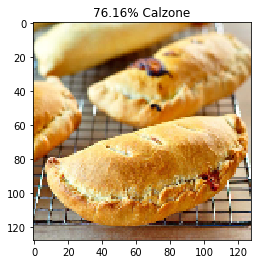

In [68]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("sample.jpg")
orig = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

im = cv2.resize(orig,(128,128))
im = np.reshape(im,(128,128,3))/255
model_out = model.predict([im])[0]
print(model_out)
pizzaness = round(model_out[1]*100, 2)
    
if pizzaness >= 50:
    str_label = '{}% Pizza'.format(pizzaness)
else:
    str_label = '{}% Calzone'.format(100-pizzaness)

plt.imshow(im,interpolation='nearest')
plt.title(str_label)
plt.show()